# CYBERBULLYING – DISTILBERT CLASSIFICATION NOTEBOOK
#

# 0. Mount google drive

In [9]:
from google.colab import drive
import os

drive.mount("/content/drive", force_remount=False)

BASE_DIR = "/content/drive/MyDrive/grunitech-project3-cyberbullying"
os.makedirs(BASE_DIR, exist_ok=True)

Mounted at /content/drive


In [63]:
import shutil

# --- Move files
# 2. Define paths
SRC_MODEL_DIR = "/content/distilbert_cyberbullying_model"
DST_MODEL_DIR = f"{BASE_DIR}/models/distilbert_bullying"

# 3. Create destination folder
os.makedirs(DST_MODEL_DIR, exist_ok=True)

# 4. Move or copy files
for file_name in os.listdir(SRC_MODEL_DIR):
    src = os.path.join(SRC_MODEL_DIR, file_name)
    dst = os.path.join(DST_MODEL_DIR, file_name)

    if os.path.isfile(src):
        shutil.copy2(src, dst)

print("✅ DistilBERT model copied to Google Drive:")
print(DST_MODEL_DIR)

✅ DistilBERT model copied to Google Drive:
/content/drive/MyDrive/grunitech-project3-cyberbullying/models/distilbert_bullying


# 1. Imports

In [4]:
!pip install sentence-transformers datasets scikit-learn umap-learn plotly
!pip install evaluate
!pip install transformers==4.57.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.3 MB/s eta 0:00:00


In [5]:

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)
import numpy as np
import evaluate

## 0.a. Attempt to load a pre-trained model from Google Drive

In [66]:
MODEL_PATH = f"{BASE_DIR}/models/distilbert_bullying"

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)

print("✅ Model and tokenizer loaded successfully from Drive")

✅ Model and tokenizer loaded successfully from Drive


# 2. Load Dataset

In [6]:
import os
from huggingface_hub import login
from google.colab import userdata

login(token=userdata.get("HF_TOKEN"))

dataset = load_dataset("cike-dev/cyberbullying_dataset")

# Inspect labels
print(dataset["train"][0])

README.md:   0%|          | 0.00/3.91k [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/2.50M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/315k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/313k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/30240 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3780 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3780 [00:00<?, ? examples/s]

{'cleaned_text': 'im so mad cause hoes think its funny', 'label': 'bully', '__index_level_0__': 3227}


## 2.a. Explore dataset

                                        cleaned_text   label  \
0               im so mad cause hoes think its funny   bully   
1         that night cap nonsense is for the birds.!  normal   
2  robertpoeti wants an explanation why the audit...  normal   
3  chris hall cbc the liberals fall strategy just...  normal   
4  user thank you finally a white person stating ...  normal   

   __index_level_0__  
0               3227  
1               5074  
2              10776  
3              11592  
4              34126  
Counts:
label
bully     15120
normal    15120
Name: count, dtype: int64

Percentages:
label
bully     50.0
normal    50.0
Name: proportion, dtype: float64


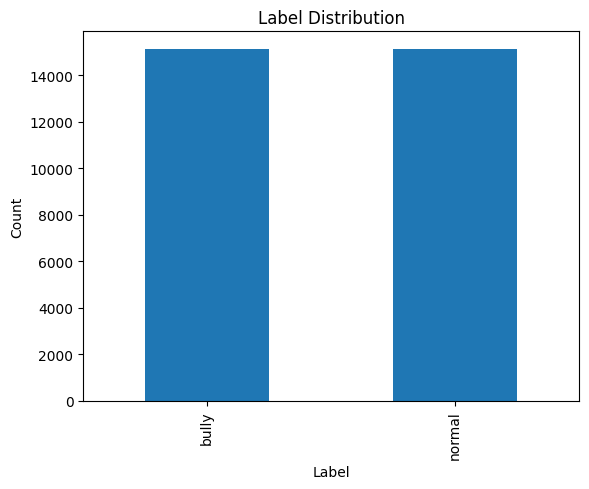

In [4]:
import pandas as pd

# Convert to pandas
df = pd.DataFrame(dataset["train"])

# Show first rows
print(df.head())

label_counts = df['label'].value_counts().sort_index()
label_percent = df['label'].value_counts(normalize=True).sort_index()

print("Counts:")
print(label_counts)

print("\nPercentages:")
print((label_percent*100).round(2))


# ----
import matplotlib.pyplot as plt

label_counts.plot(kind="bar")
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

## 2.b. Convert label column to integers

In [7]:
from datasets import ClassLabel

label2id = {'normal': 0, 'bully': 1}
id2label = {0: 'normal', 1: 'bully'}

# Define the 'map' function to use in the mapping process
def encode_labels(batch):
    batch["label"] = [label2id[x] for x in batch["label"]]
    return batch

# Convert the strings ('bully', 'normal') to (1, 0) respectively
dataset = dataset.map(encode_labels, batched=True)

# Now recast the column from 'str' to 'int'
dataset = dataset.cast_column(
    "label",
    ClassLabel(num_classes=2, names=["normal", "bully"])
)

# Explore the fix
print(dataset["train"][:5])

Map:   0%|          | 0/30240 [00:00<?, ? examples/s]

Map:   0%|          | 0/3780 [00:00<?, ? examples/s]

Map:   0%|          | 0/3780 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/30240 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3780 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3780 [00:00<?, ? examples/s]

{'cleaned_text': ['im so mad cause hoes think its funny', 'that night cap nonsense is for the birds.!', 'robertpoeti wants an explanation why the auditor general of quebec is conflicted in this amf investigation! perhaps he cant read and cant follow the trail of evidence that proves she is conflicted url sad. corruption, nathaliegdrouin, pennystocks', 'chris hall cbc the liberals fall strategy just hit a brick wall named leona alleslev url', 'user thank you finally a white person stating facts'], 'label': [1, 0, 0, 0, 0], '__index_level_0__': [3227, 5074, 10776, 11592, 34126]}


# 3. Define tokenizer

In [46]:
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def preprocess(batch):
    return tokenizer(
        batch["cleaned_text"],
        padding="max_length",
        truncation=True
    )

tokenized = dataset.map(preprocess, batched=True)

Map:   0%|          | 0/30240 [00:00<?, ? examples/s]

Map:   0%|          | 0/3780 [00:00<?, ? examples/s]

Map:   0%|          | 0/3780 [00:00<?, ? examples/s]

# 4. Data Collator

In [47]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 5. Load Model

In [48]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



# 6. Metrics

In [49]:
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels)["f1"]
    }

# 7. Training Setup

In [50]:
from transformers import TrainingArguments
import transformers

!pip show transformers

training_args = TrainingArguments(
    output_dir="distilbert_bullying_results",
    learning_rate=2e-5,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    weight_decay=0.01,
    load_best_model_at_end=True,
)

Name: transformers
Version: 4.57.3
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.12/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: peft, sentence-transformers


# 8. Trainer

In [51]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# 9. Train

In [52]:
print(dataset["train"]["cleaned_text"][:5])
print(dataset["train"]["label"][:5])
print(dataset["train"].features)

['im so mad cause hoes think its funny', 'that night cap nonsense is for the birds.!', 'robertpoeti wants an explanation why the auditor general of quebec is conflicted in this amf investigation! perhaps he cant read and cant follow the trail of evidence that proves she is conflicted url sad. corruption, nathaliegdrouin, pennystocks', 'chris hall cbc the liberals fall strategy just hit a brick wall named leona alleslev url', 'user thank you finally a white person stating facts']
[1, 0, 0, 0, 0]
{'cleaned_text': Value('string'), 'label': ClassLabel(names=['normal', 'bully']), '__index_level_0__': Value('int64')}


In [53]:
import wandb

os.environ["WANDB_API_KEY"] = userdata.get("w&b_api_key")
wandb.login(key=os.environ["WANDB_API_KEY"])

trainer.train()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.449800,0.475868,0.788624,0.797157
2,0.350700,0.488430,0.798148,0.799685
3,0.258100,0.556912,0.794974,0.797597


TrainOutput(global_step=5670, training_loss=0.3639792003328838, metrics={'train_runtime': 988.873, 'train_samples_per_second': 91.741, 'train_steps_per_second': 5.734, 'total_flos': 1.201744240607232e+16, 'train_loss': 0.3639792003328838, 'epoch': 3.0})

# 10. Evaluate

In [54]:

results = trainer.evaluate()
print(results)

{'eval_loss': 0.475868284702301, 'eval_accuracy': 0.7886243386243387, 'eval_f1': 0.7971566387407971, 'eval_runtime': 14.6052, 'eval_samples_per_second': 258.812, 'eval_steps_per_second': 16.227, 'epoch': 3.0}


## 10.a. Loss curves

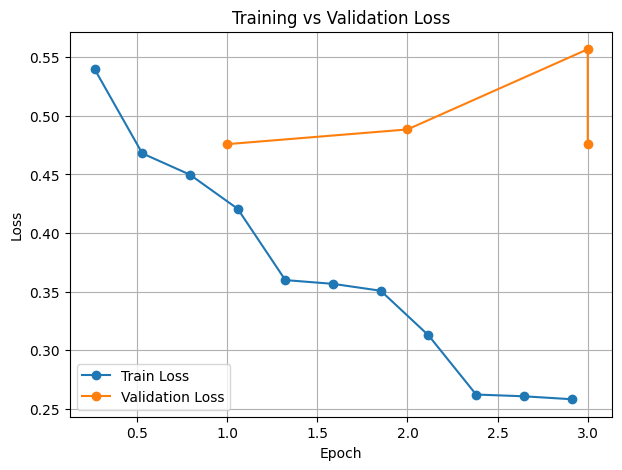

In [58]:
import matplotlib.pyplot as plt

log_history = trainer.state.log_history

train_epochs = []
train_loss = []

eval_epochs = []
eval_loss = []

for log in log_history:
    if "loss" in log and "epoch" in log:
        train_loss.append(log["loss"])
        train_epochs.append(log["epoch"])

    if "eval_loss" in log and "epoch" in log:
        eval_loss.append(log["eval_loss"])
        eval_epochs.append(log["epoch"])

plt.figure(figsize=(7,5))
plt.plot(train_epochs, train_loss, label="Train Loss", marker="o")
plt.plot(eval_epochs, eval_loss, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

## 10.b. Confusion matrix


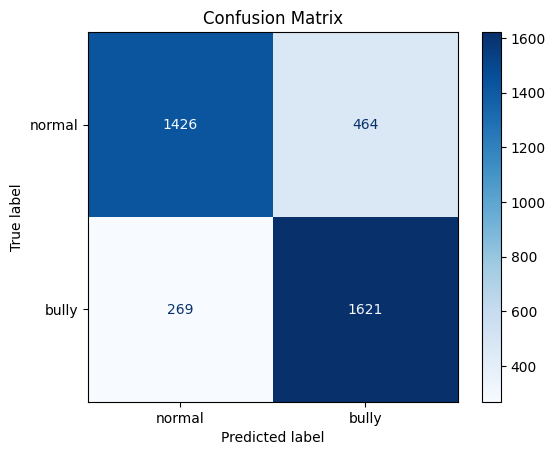

In [56]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = trainer.predict(tokenized["validation"])
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)


cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["normal", "bully"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

## 10.c. F1

In [57]:
from sklearn.metrics import classification_report

print(
    classification_report(
        y_true,
        y_pred,
        target_names=["normal", "bully"],
        digits=4
    )
)

              precision    recall  f1-score   support

      normal     0.8413    0.7545    0.7955      1890
       bully     0.7775    0.8577    0.8156      1890

    accuracy                         0.8061      3780
   macro avg     0.8094    0.8061    0.8056      3780
weighted avg     0.8094    0.8061    0.8056      3780



# 11. Save final model

In [59]:
trainer.save_model(f"{BASE_DIR}/models/distilbert_bullying")
tokenizer.save_pretrained(f"{BASE_DIR}/models/distilbert_bullying")

('distilbert_cyberbullying_model/tokenizer_config.json',
 'distilbert_cyberbullying_model/special_tokens_map.json',
 'distilbert_cyberbullying_model/vocab.txt',
 'distilbert_cyberbullying_model/added_tokens.json',
 'distilbert_cyberbullying_model/tokenizer.json')

# 12. Add probabilities to dataset

## 12.a. Load pre-trained dataset

In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

MODEL_PATH = f"{BASE_DIR}/models/distilbert_bullying"

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)

model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


## 12.b. Define 'predict_with_confidence' function

In [12]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

def predict_with_confidence(
    texts,
    model,
    tokenizer,
    batch_size=32,
    device=None
):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    model.to(device)
    model.eval()

    all_preds = []
    all_confs = []

    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size)):
            batch_texts = texts[i:i + batch_size]

            inputs = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=128,
                return_tensors="pt"
            )

            inputs = {k: v.to(device) for k, v in inputs.items()}

            outputs = model(**inputs)
            probs = F.softmax(outputs.logits, dim=1)

            bully_probs = probs[:, 1]   # index 1 = bully
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().tolist())
            all_confs.extend(bully_probs.cpu().tolist())

    return all_preds, all_confs

## 12.c. Run example

In [14]:
texts = [
    "you are such an idiot",
    "nice photo!"
]

preds, confs = predict_with_confidence(texts, model, tokenizer)

for t, p, c in zip(texts, preds, confs):
    print(f"Text: {t}")
    print(f"Prediction: {p}, Bullying confidence: {c:.3f}\n")

100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

Text: you are such an idiot
Prediction: 1, Bullying confidence: 0.945

Text: nice photo!
Prediction: 0, Bullying confidence: 0.046



# 13. Save new dataset (with confidence score)

In [15]:
import pandas as pd

def add_confidence_column(dataset_split, model, tokenizer):
    texts = list(dataset_split["cleaned_text"])
    labels = list(dataset_split["label"])

    preds, confs = predict_with_confidence(
        texts,
        model=model,
        tokenizer=tokenizer,
        batch_size=32
    )

    return pd.DataFrame({
        "cleaned_text": texts,
        "label": labels,
        "bullying_confidence": confs
    })

df_train = add_confidence_column(dataset["train"], model, tokenizer)
df_test = add_confidence_column(dataset["test"], model, tokenizer)

df = pd.concat([df_train, df_test])


100%|██████████| 119/119 [00:01<00:00, 66.14it/s]


In [18]:
df.to_parquet(
    f"{BASE_DIR}/data/processed/messages_with_confidence.parquet",
    index=False
)